In [5]:
# Import Required Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

import warnings
warnings.filterwarnings("ignore")

sns.set(style="whitegrid")


In [2]:
# Load Dataset

df = pd.read_csv("CloudWatch_Traffic_Web_Attack.csv")

df.head()


,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
0,5602,12990,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
1,30912,18186,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
2,28506,13468,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
3,30546,14278,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
4,6526,13892,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   bytes_in             282 non-null    int64 
 1   bytes_out            282 non-null    int64 
 2   creation_time        282 non-null    object
 3   end_time             282 non-null    object
 4   src_ip               282 non-null    object
 5   src_ip_country_code  282 non-null    object
 6   protocol             282 non-null    object
 7   response.code        282 non-null    int64 
 8   dst_port             282 non-null    int64 
 9   dst_ip               282 non-null    object
 10  rule_names           282 non-null    object
 11  observation_name     282 non-null    object
 12  source.meta          282 non-null    object
 13  source.name          282 non-null    object
 14  time                 282 non-null    object
 15  detection_types      282 non-null    object
dtypes: int64

In [6]:
#Data Cleaning & Preprocessing
# Remove duplicates
df = df.drop_duplicates()

# Convert datetime columns
df['creation_time'] = pd.to_datetime(df['creation_time'])
df['end_time'] = pd.to_datetime(df['end_time'])
df['time'] = pd.to_datetime(df['time'])

# Standardize country codes
df['src_ip_country_code'] = df['src_ip_country_code'].str.upper()

df.isnull().sum()


bytes_in               0
bytes_out              0
creation_time          0
end_time               0
src_ip                 0
src_ip_country_code    0
protocol               0
response.code          0
dst_port               0
dst_ip                 0
rule_names             0
observation_name       0
source.meta            0
source.name            0
time                   0
detection_types        0
dtype: int64

In [7]:
#Feature Engineering
# Session duration (seconds)
df['session_duration'] = (df['end_time'] - df['creation_time']).dt.total_seconds()

# Average packet size
df['avg_packet_size'] = (df['bytes_in'] + df['bytes_out']) / df['session_duration']

df[['session_duration', 'avg_packet_size']].head()


,session_duration,avg_packet_size
0,600.0,30.986667
1,600.0,81.830000
2,600.0,69.956667
3,600.0,74.706667
4,600.0,34.030000


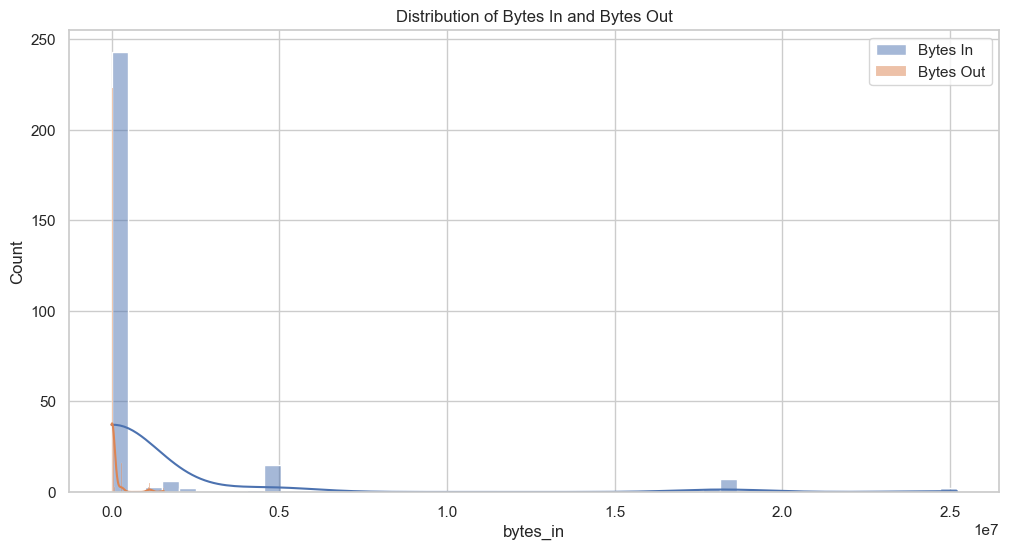

In [8]:
# Exploratory Data Analysis (EDA)
# Bytes In vs Bytes Out Distribution

plt.figure(figsize=(12,6))
sns.histplot(df['bytes_in'], bins=50, kde=True, label='Bytes In')
sns.histplot(df['bytes_out'], bins=50, kde=True, label='Bytes Out')
plt.legend()
plt.title("Distribution of Bytes In and Bytes Out")
plt.show()


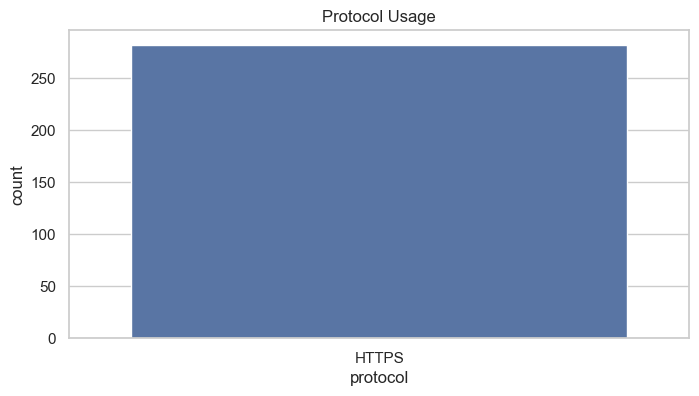

In [9]:
# Protocol Usage Count

plt.figure(figsize=(8,4))
sns.countplot(x='protocol', data=df)
plt.title("Protocol Usage")
plt.show()


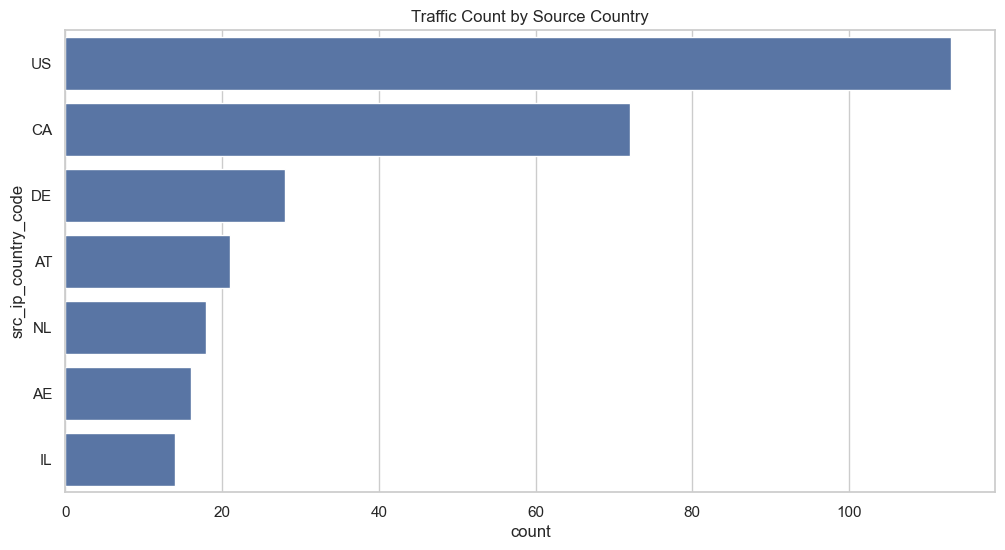

In [10]:
# Country-wise Traffic Analysis

plt.figure(figsize=(12,6))
sns.countplot(y='src_ip_country_code', 
              order=df['src_ip_country_code'].value_counts().index,
              data=df)
plt.title("Traffic Count by Source Country")
plt.show()


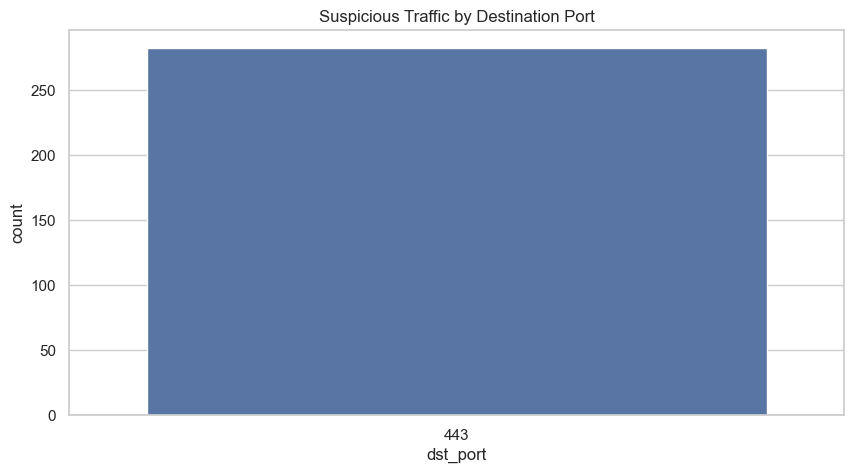

In [11]:
# Suspicious Traffic by Destination Port

plt.figure(figsize=(10,5))
sns.countplot(x='dst_port', 
              data=df[df['detection_types'] == 'waf_rule'])
plt.title("Suspicious Traffic by Destination Port")
plt.show()


In [12]:
# Feature Scaling

scaler = StandardScaler()

scaled_features = scaler.fit_transform(
    df[['bytes_in', 'bytes_out', 'session_duration', 'avg_packet_size']]
)

scaled_df = pd.DataFrame(
    scaled_features,
    columns=['bytes_in_scaled','bytes_out_scaled',
             'session_duration_scaled','avg_packet_size_scaled']
)

df = pd.concat([df.reset_index(drop=True), scaled_df], axis=1)


In [13]:
# Anomaly Detection (Isolation Forest)

iso_model = IsolationForest(contamination=0.05, random_state=42)

df['anomaly'] = iso_model.fit_predict(
    df[['bytes_in_scaled','bytes_out_scaled',
        'session_duration_scaled','avg_packet_size_scaled']]
)

df['anomaly'] = df['anomaly'].map({1:'Normal', -1:'Suspicious'})
df['anomaly'].value_counts()


anomaly
Normal        267
Suspicious     15
Name: count, dtype: int64

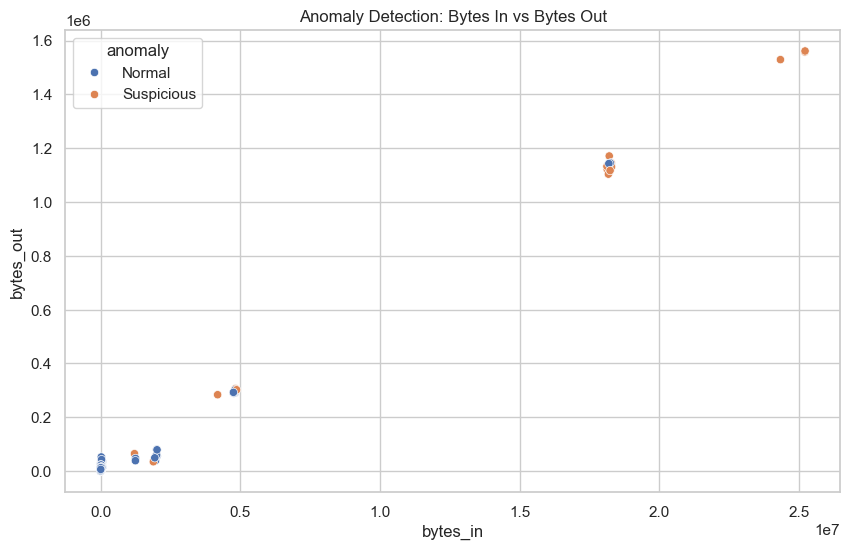

In [14]:
# Anomaly Visualization

plt.figure(figsize=(10,6))
sns.scatterplot(
    x='bytes_in', 
    y='bytes_out', 
    hue='anomaly', 
    data=df
)
plt.title("Anomaly Detection: Bytes In vs Bytes Out")
plt.show()


In [15]:
# Supervised Learning – Random Forest Classifier
# Label Encoding

df['is_suspicious'] = (df['detection_types'] == 'waf_rule').astype(int)


In [16]:
# Train-Test Split

X = df[['bytes_in', 'bytes_out', 'session_duration', 'avg_packet_size']]
y = df['is_suspicious']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


In [17]:
# Model Training

rf_model = RandomForestClassifier(
    n_estimators=100, random_state=42
)

rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)


In [18]:
# Model Evaluation

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 1.0
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        85

    accuracy                           1.00        85
   macro avg       1.00      1.00      1.00        85
weighted avg       1.00      1.00      1.00        85



In [19]:
# Key Findings & Insights

df[df['anomaly'] == 'Suspicious'][[
    'src_ip', 'src_ip_country_code',
    'bytes_in', 'bytes_out',
    'dst_port'
]].head()


,src_ip,src_ip_country_code,bytes_in,bytes_out,dst_port
36,155.91.45.242,US,4190330,283456,443
87,165.225.240.79,NL,1215594,64362,443
116,155.91.45.242,US,4827283,306181,443
132,165.225.240.79,NL,1889834,34306,443
153,155.91.45.242,US,4869181,301752,443
